In [1]:
import numpy as np
import tensorflow as tf
import keras
from pydub import AudioSegment
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

Using TensorFlow backend.
C:\Users\Dev\Miniconda3\envs\tensorflow\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
model = tf.keras.models.load_model('good_model.h5', custom_objects=None, compile=True)

In [3]:
ons,offs,negatives,backgrounds = load_raw_audio()

In [4]:
def get_random_time_segment(segment_ms):

    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

def is_overlapping(segment_time,previous_segments):
    segment_start, segment_end = segment_time
    overlap = False
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True     
    
    return overlap

def insert_audio_clip(background, audio_clip, previous_segments):
    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(segment_ms)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)
    previous_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

def insert_ones(y,segment_end_ms):
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < y.shape[1]:
            y[0, i] = 1
    return y

def insert_twos(y,segment_end_ms):
    segment_end_y = int(segment_end_ms*Ty/10000.0)
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < y.shape[1]:
            y[0, i] = 2
    return y

def create_training_example(background, ons,offs, negatives):
    background = background - 20
    y = np.zeros((1,Ty))
    previous_segments = []
    number_of_ons = np.random.randint(1, 3)
    random_indices = np.random.randint(len(ons), size=number_of_ons)
    random_ons = [ons[i] for i in random_indices]
    for random_on in random_ons:
        background, segment_time = insert_audio_clip(background, random_on, previous_segments)
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end)
    
    number_of_offs = np.random.randint(1, 3)
    random_indices = np.random.randint(len(offs), size=number_of_offs)
    random_offs = [offs[i] for i in random_indices]
    for random_off in random_offs:
        background, segment_time = insert_audio_clip(background, random_off, previous_segments)
        segment_start, segment_end = segment_time
        y = insert_twos(y, segment_end)
        
        
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]
    for random_negative in random_negatives:
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    background = match_target_amplitude(background, -20.0)
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    x = graph_spectrogram("train.wav")
    
    return x, y

In [5]:
Tx = 5511
n_freq = 101
Ty = 1375

def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    print(predictions.shape)
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,1],label = 'on pred')
    plt.plot(predictions[0,:,2], label = 'off_pred')
    plt.ylabel('probability')
    plt.legend()
    plt.show()
    return predictions


chime_file = "chime.wav"
beep_file = 'beep.wav'
def chime_on_activate(filename, predictions, threshold_on, threshold_off):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    beep = AudioSegment.from_wav(beep_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,1]>threshold_on and predictions[0,i,1]>predictions[0,i,2] and consecutive_timesteps>75 :
            audio_clip = audio_clip.overlay(beep, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            consecutive_timesteps = 0
            
        if predictions[0,i,2] > threshold_off and predictions[0,i,2]>predictions[0,i,1] and consecutive_timesteps > 75:
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            consecutive_timesteps = 0
    
    audio_clip.export("chime_output.wav", format='wav')

File (train.wav) was saved in your directory.


C:\Users\Dev\Miniconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(1, 1375, 3)


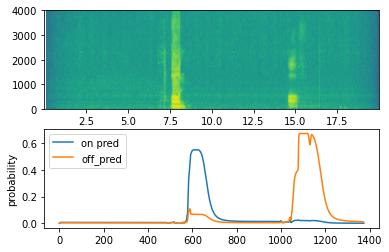

In [6]:
# Perfect Output
_,_ = create_training_example(backgrounds[2], ons,offs, negatives)
IPython.display.Audio("./train.wav")

filename = "./train.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.4,0.4)
IPython.display.Audio("./chime_output.wav")

File (train.wav) was saved in your directory.


C:\Users\Dev\Miniconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(1, 1375, 3)


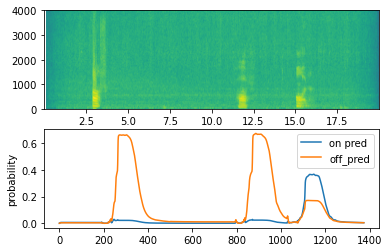

In [7]:
# Missed On (didn't reach threshold) though the probability was high

_,_ = create_training_example(backgrounds[2], ons,offs, negatives)
IPython.display.Audio("./train.wav")

filename = "./train.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.4,0.4)
IPython.display.Audio("./chime_output.wav")

File (train.wav) was saved in your directory.


C:\Users\Dev\Miniconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(1, 1375, 3)


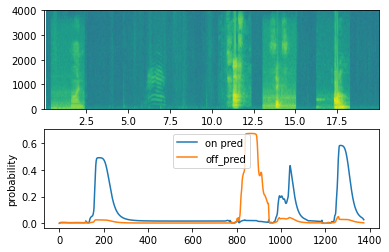

In [9]:
# This example shows the model still needs to improve in detecting negatives 

_,_ = create_training_example(backgrounds[1], ons,offs, negatives)
IPython.display.Audio("./train.wav")

filename = "./train.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.4,0.4)
IPython.display.Audio("./chime_output.wav")